# Linear Regression Implementation



In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## Dataset Generation

We will generate synthetic data with a linear distribution.

To be more realistic, we add noise $\epsilon$ to the data. You could think of $\epsilon$ as capturing potential measurement errors on the features and labels.

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

We generate 1000 examples, each consisting of 2 features drawn from a standard normal distribution.
Thus our synthetic dataset will be a matrix $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

In [2]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Each row in `features` consists of a vector in $\mathbb{R}^2$ and each row in `labels` is a scalar

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.1641,  1.1038]) 
label: tensor([0.1235])


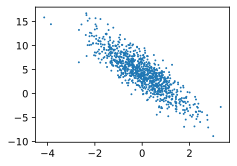

In [4]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

Define the `data_iter` function.
Takes a batch size, a matrix of features, and a vector of labels and generates minibatches of size `batch_size`
Each minibatch consists of a tuple of features and labels.

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

Call the existing API in a framework to load data

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.3508,  0.7689],
        [ 1.2861, -1.2084],
        [ 0.0075, -0.9856],
        [-0.2834, -0.7878],
        [ 0.0180, -0.5527],
        [ 0.9886,  1.1267],
        [ 0.5927,  0.3208],
        [ 0.9133, -1.1309],
        [ 0.6491, -0.6683],
        [-0.1850, -0.3806]]) 
 tensor([[-1.1228],
        [10.8771],
        [ 7.5846],
        [ 6.3102],
        [ 6.1159],
        [ 2.3434],
        [ 4.3046],
        [ 9.8861],
        [ 7.7789],
        [ 5.1297]])


## Model Definition

To train using minibatch SGD, we first need to initialize model's parameters.

We will initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):
    return torch.matmul(X, w) + b

To calculate the output of the linear model, we simply take the matrix-vector dot product of the input features $X$ and the model weights $w$, and add the offset $b$ to each example.

## Train The Model

Since updating our model requires taking the gradient of our loss function with respect to the parameters, we have to define the loss function first.

Given this gradient, we can update each parameter in the direction that may reduce the loss.

**Squared error** $$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

In [8]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

We use automatic differentiation to estimate the gradient of the loss with respect to our parameters using one minibtach randomly drawn from our dataset

Next, we update our parameters in the direction that may reduce the loss.

The size of the update step is determined by the learning rate ```lr```.

Because our loss is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size, so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [9]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In each ```epoch```, we will execute the following loop:

<ol>
        <li>Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$</li>
        <li>Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$</li>
</ol>

In [10]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033299
epoch 2, loss 0.000118
epoch 3, loss 0.000051


Because we have generated the data ourselves, we know the true parameters and we can compare

In [11]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-5.2691e-05, -4.3106e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0001], grad_fn=<RsubBackward1>)


Convergeance to optimal solution in **not guarantee**

Most of the time we converge to a ```local minimum``` (or a ```saddle point```)

In practice, we often reach a good solution **if correct initialization**